# Linear Discriminant Analysis (LDA)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [2]:
pd.options.display.max_columns = None

## Load the data into dataframe

In [3]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [8]:
df_wine.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')

In [4]:
df_wine.shape

(178, 14)

In [5]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X.shape, y.shape

((178, 13), (178,))

In [6]:
# classes for target variable '0'
np.unique(y)

array([1, 2, 3])

## LDA from scratch

### Within class matrix

For every class, we create a vector with the means of each feature.

$m_i = \frac{1}{n_i}\sum_{x \in D_i}^{n}{x_k}$

In [21]:
class_feature_means = pd.DataFrame(columns=[1, 2, 3])

for c, rows in df_wine.groupby(0):
    class_feature_means[c] = rows.iloc[:,1:].mean()

# class_feature_means.reset_index(drop=True, inplace=True)
class_feature_means

,1,2,3
1,13.744746,12.278732,13.153750
2,2.010678,1.932676,3.333750
3,2.455593,2.244789,2.437083
4,17.037288,20.238028,21.416667
5,106.338983,94.549296,99.312500
6,2.840169,2.258873,1.678750
7,2.982373,2.080845,0.781458
8,0.290000,0.363662,0.447500
9,1.899322,1.630282,1.153542
10,5.528305,3.086620,7.396250


Plugin $m_i$ into the following equation to get within class Scatter matrix:

$ S_i = \sum_{x \in D_i}^{n} (x - m_i)(x-m_i)^T $

In [25]:
within_class_scatter_matrix = np.zeros((13, 13))

for c, rows in df_wine.groupby(0):
    rows = rows.drop(0, axis=1)
    s = np.zeros((13, 13))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(13, 1), class_feature_means[c].values.reshape(13, 1)
        s += (x-mc).dot((x-mc).T)
    within_class_scatter_matrix += s

In [26]:
pd.DataFrame(within_class_scatter_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,45.859182,1.430276,-2.329110,-17.013018,3.138271,4.742176,3.960549,-0.170720,2.934978,43.130146,0.136868,-0.872439,2.141495e+03
1,1.430276,155.320689,3.743391,72.582283,-155.634176,-2.534868,-1.646618,1.780654,3.010536,-45.272514,-7.373182,8.142634,-5.785236e+03
2,-2.329110,3.743391,11.562618,84.728099,120.665125,2.829752,5.244934,1.228605,0.469124,1.713984,0.406392,1.909503,-8.767189e+01
3,-17.013018,72.582283,84.728099,1401.191957,566.621139,19.007669,43.123331,8.210113,16.226898,-17.814143,-1.720402,39.485563,-5.745752e+03
4,3.138271,-155.634176,120.665125,566.621139,31615.110304,100.999304,116.697710,-50.235317,227.569448,310.171993,22.077711,-49.197790,8.334355e+04
5,4.742176,-2.534868,2.829752,19.007669,100.999304,33.472333,28.228731,-1.353757,16.072642,34.821922,-0.256415,10.476063,1.469197e+03
6,3.960549,-1.646618,5.244934,43.123331,116.697710,28.228731,48.073815,-2.671745,22.363830,50.168703,-0.736111,11.875839,5.994972e+02
7,-0.170720,1.780654,1.228605,8.210113,-50.235317,-1.353757,-2.671745,2.084548,-1.512148,-0.264371,0.237752,-1.762567,-8.630433e+01
8,2.934978,3.010536,0.469124,16.226898,227.569448,16.072642,22.363830,-1.512148,43.080265,40.111238,-1.103525,7.427303,2.009406e+03
9,43.130146,-45.272514,1.713984,-17.814143,310.171993,34.821922,50.168703,-0.264371,40.111238,399.861539,-7.174341,-11.603398,1.191639e+04


### Between class scatter matrix

$ S_B = \sum_{i=1}^{c} N_i (m_i - m)(m_i - m)^T $, 

where

$ m = \frac{1}{n}\sum_{i}^{n} x_i $

In [28]:
feature_means = df_wine.iloc[:, 1:].mean()
between_class_scatter_matrix = np.zeros((13, 13))

for c in class_feature_means:
    n = len(df_wine.loc[df_wine[0] == c].index)

    mc, m = class_feature_means[c].values.reshape(13, 1), feature_means.values.reshape(13, 1)

    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

In [30]:
pd.DataFrame(between_class_scatter_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,70.794850,13.722926,10.668493,-131.860426,552.620156,21.256862,30.029331,-2.617784,8.307623,138.875865,-2.493348,8.252953,2.698690e+04
1,13.722926,65.578037,5.155645,117.928430,1.506198,-38.942909,-79.530957,5.429151,-27.993552,159.408872,-17.995455,-59.905838,-6.170913e+03
2,10.668493,5.155645,1.759223,-12.829234,78.094650,1.090017,0.336713,-0.103155,-0.200866,27.429832,-1.235134,-1.774658,3.507266e+03
3,-131.860426,117.928430,-12.829234,572.833493,-1270.153723,-137.801068,-250.581989,18.414556,-82.987089,43.483423,-35.293494,-155.639047,-7.626814e+04
4,552.620156,1.506198,78.094650,-1270.153723,4491.002056,238.215865,377.678695,-30.399402,114.541900,861.660156,9.932963,167.665318,2.297975e+05
5,21.256862,-38.942909,1.090017,-137.801068,238.215865,35.856715,67.434533,-4.849230,22.756440,-48.981483,11.237296,44.574704,1.590708e+04
6,30.029331,-79.530957,0.336713,-250.581989,377.678695,67.434533,128.522390,-9.163714,43.683287,-120.821550,22.698620,86.936580,2.691471e+04
7,-2.617784,5.429151,-0.103155,18.414556,-30.399402,-4.849230,-9.163714,0.656940,-3.100448,7.365701,-1.560150,-6.108490,-2.073730e+03
8,8.307623,-27.993552,-0.200866,-82.987089,114.541900,22.756440,43.683287,-3.100448,14.903991,-46.041431,7.947153,29.907828,8.531711e+03
9,138.875865,159.408872,27.429832,43.483423,861.660156,-48.981483,-120.821550,7.365701,-46.041431,551.416002,-41.767185,-113.325428,2.892945e+04


Solve the generalized eigenvalue problem for 

$ S_{W}^{-1} S_B $

to obtain the linear discriminants.

In [31]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

In [32]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]

pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

for pair in pairs:
    print(pair[0])

9.081739435042467
4.128469045639491
7.998757471523068e-16
7.998757471523068e-16
7.320717057228145e-16
5.312424111653645e-16
5.312424111653645e-16
3.276911013211057e-16
2.865224007976218e-16
1.194010991462046e-16
1.194010991462046e-16
2.2244693638046923e-17
0.0


In [33]:
eigen_value_sums = sum(eigen_values)

print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.6874788878860778
Eigenvector 1: 0.31252111211392214
Eigenvector 2: 6.054982011237829e-17
Eigenvector 3: 6.054982011237829e-17
Eigenvector 4: 5.5417119782277826e-17
Eigenvector 5: 4.021453650351019e-17
Eigenvector 6: 4.021453650351019e-17
Eigenvector 7: 2.4805899301309823e-17
Eigenvector 8: 2.168946850586195e-17
Eigenvector 9: 9.038547674763169e-18
Eigenvector 10: 9.038547674763169e-18
Eigenvector 11: 1.6839017847883785e-18
Eigenvector 12: 0.0


In [34]:
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real

In [35]:
X_lda = np.array(X.dot(w_matrix))

In [36]:
le = LabelEncoder()
y = le.fit_transform(y)

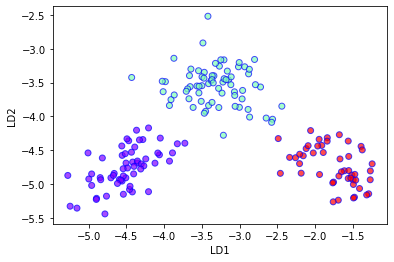

In [38]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
plt.show()